#### authors: Rafael Dousse, Eva Ray, Massimo Stefani

# PW4 - Linear Regression

## Imports

In [208]:
import random
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

## Load data

Define the path to the file containing the data

In [209]:
datafile = "lausanne-appart.csv"

Read the data

In [210]:
dataset = pd.read_csv(datafile)

Display first rows

In [211]:
dataset.head()

,living_area,nb_rooms,rent_price
0,69,3.0,1810
1,95,3.5,2945
2,21,1.5,685
3,20,1.0,720
4,33,1.5,830


## Exercise 1 - Visualize the data

a) Plot a histogram to visualize the distribution of the renting price

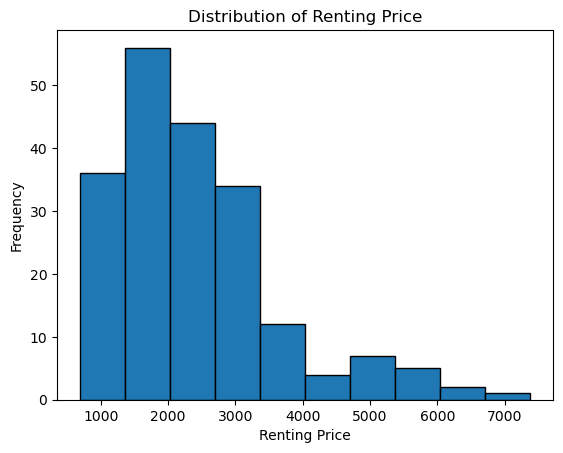

In [212]:
# Your code here
plt.hist(dataset['rent_price'], edgecolor='black')
plt.title('Distribution of Renting Price')
plt.xlabel('Renting Price')
plt.ylabel('Frequency')
plt.show()

b) Plot a histogram to visualize the distribution of the living area

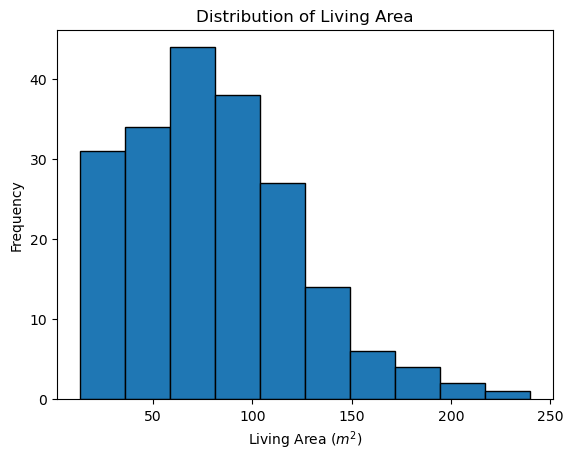

In [213]:
# Your code here
plt.hist(dataset['living_area'], edgecolor='black')
plt.title('Distribution of Living Area')
plt.xlabel('Living Area ($m^2$)')
plt.ylabel('Frequency')
plt.show()

c) Plot a scatter plot of renting price as a function of living area

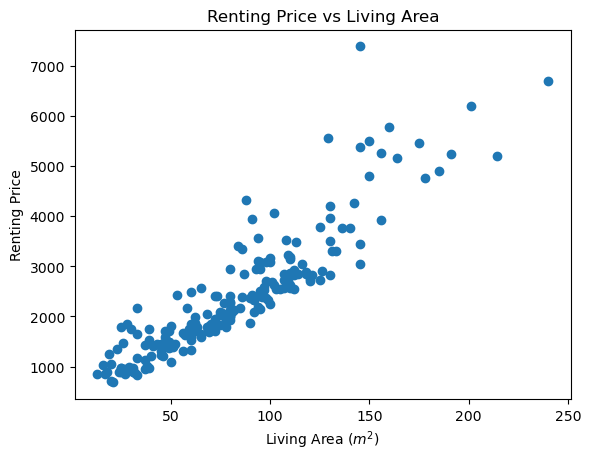

In [214]:
# Your code here
plt.scatter(dataset['living_area'], dataset['rent_price'])
plt.title('Renting Price vs Living Area')
plt.xlabel('Living Area ($m^2$)')
plt.ylabel('Renting Price')
plt.show()

## Exercise 2 - Normal equations for linear regression

a) Implement the closed form solution to this problem using the following normal equation:

$$\theta = (X^{T}X)^{-1}X^{T}\vec{y} \tag{3}$$

Assuming $x$ is the living area and $y$ is the renting price. Use `numpy` for the vector operations. Plot the computed line on top of the scatter plot of exercise 1.

In [215]:
X = dataset[['living_area', 'nb_rooms']].to_numpy(dtype=float)
y = dataset['rent_price'].to_numpy(dtype=float)

# The first column of X must be all ones
ones = np.ones((X.shape[0], 1))
X = np.hstack((ones, X))

theta_i = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
# apparently, it's better and more stable to use pinv (or even solve() or lstsq() instead of inv)
theta_pi = np.dot(np.linalg.pinv(X), y)

print("Theta (using inv):", theta_i)
print("Theta (using pinv):", theta_pi)

Theta (using inv): [286.93086826  28.66118876 -76.06313749]
Theta (using pinv): [286.93086826  28.66118876 -76.06313749]


Assuming $x$ is the living area and $y$ is the renting price. Use `numpy` for the vector operations. Plot the computed line on top of the scatter plot of exercise 1.

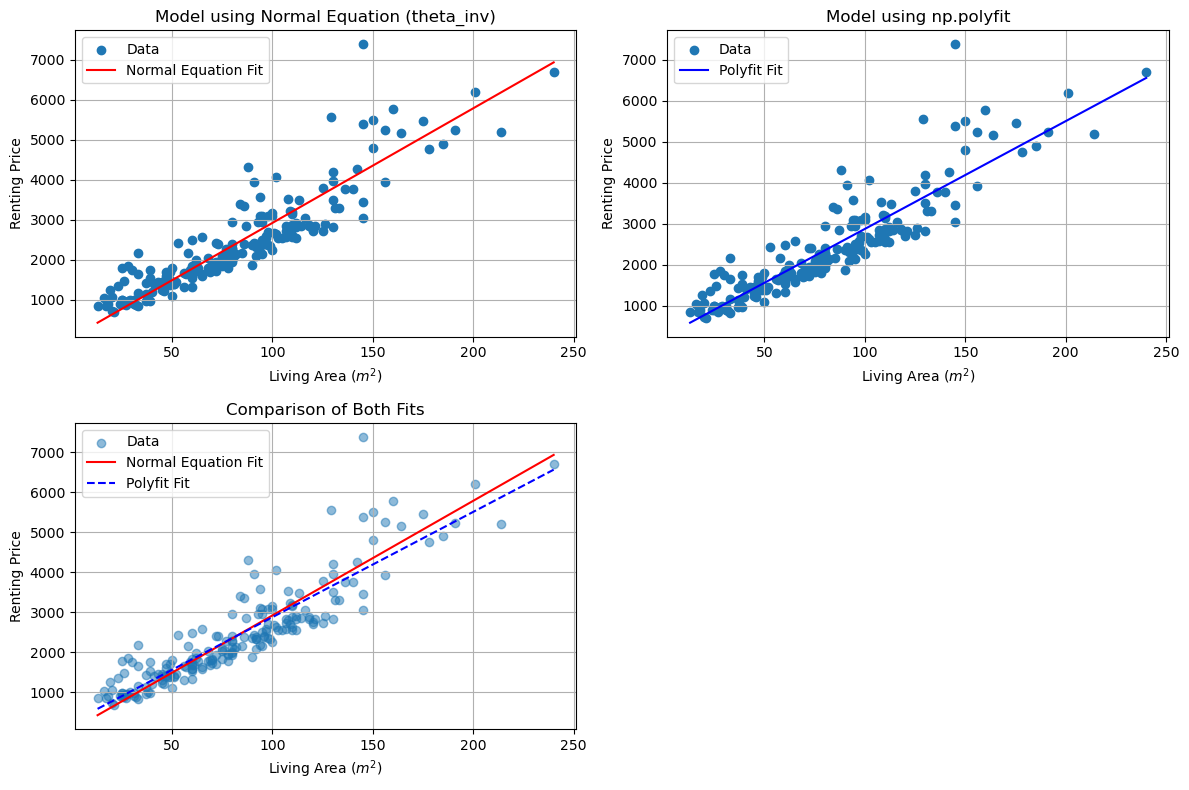

In [216]:
# we generate points between min and max of living_area for plotting the regression line
x_line = np.linspace(dataset['living_area'].min(), dataset['living_area'].max(), 200)
# here we create a constant array for nb_rooms, using the mean of the dataset
rooms_const = np.full_like(x_line, dataset['nb_rooms'].mean())
# Then we create the matrix with the same structure as X for prediction
X_line = np.column_stack([np.ones_like(x_line), x_line, rooms_const])
# Now we can compute the predicted y values using our model
y_line = X_line.dot(theta_i)

# We also compute the poly fit for comparison
coeffs = np.polyfit(dataset['living_area'], dataset['rent_price'], 1)
model = np.poly1d(coeffs)
y_polyfit = model(x_line)

# We create a 2x2 subplot grid to compare the two models
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
(ax1, ax2), (ax3, _) = axs 

# First subplot using Normal Equation
ax1.scatter(dataset['living_area'], dataset['rent_price'], label="Data")
ax1.plot(x_line, y_line, color='red', label="Normal Equation Fit")
ax1.set_title('Model using Normal Equation (theta_inv)')
ax1.set_xlabel('Living Area ($m^2$)')
ax1.set_ylabel('Renting Price')
ax1.legend()
ax1.grid(True)

# Second subplot using Polyfit
ax2.scatter(dataset['living_area'], dataset['rent_price'], label="Data")
ax2.plot(x_line, y_polyfit, color='blue', label="Polyfit Fit")
ax2.set_title('Model using np.polyfit')
ax2.set_xlabel('Living Area ($m^2$)')
ax2.set_ylabel('Renting Price')
ax2.legend()
ax2.grid(True)

# Third subplot comparing both models on the same plot
ax3.scatter(dataset['living_area'], dataset['rent_price'], alpha=0.5, label="Data")
ax3.plot(x_line, y_line, color='red', label="Normal Equation Fit")
ax3.plot(x_line, y_polyfit, color='blue', linestyle='--', label="Polyfit Fit")
ax3.set_title('Comparison of Both Fits')
ax3.set_xlabel('Living Area ($m^2$)')
ax3.set_ylabel('Renting Price')
ax3.legend()
ax3.grid(True)

# we don't need the fourth subplot, so we remove it
fig.delaxes(axs[1, 1])

# Finally, we can adjust layout and show the plots
plt.tight_layout()
plt.show()


b) Compute the overall cost value according to the following equation:

$$J(\theta) = \frac{1}{2N} \sum_{n=1}^{N} (h_{\theta}(\mathbf{x}_{n}) - y_{n})^{2} \tag{2}$$

In [217]:
def mse_cost(theta, X, y):
    """
    Mean squared error cost function.
    J(theta) = (1/2m) * Σ(h_theta(x) - y)²
    """
    m = len(y)
    predictions = X.dot(theta)
    errors = predictions - y
    return (1/(2*m)) * np.sum(errors ** 2)

## Exercise 3 - Gradient descent for linear regression

Implement the _full batch_ gradient descent algorithm for the previous problem. As seen in the
theory, the update rules are:

$$\theta_{0} \leftarrow \theta_{0} - \alpha \frac{1}{N} \sum_{n=1}^{N} (h_{\theta}(\mathbf{x}_{n}) - y_{n}) \tag{6}$$

$$\theta_{1} \leftarrow \theta_{1} - \alpha \frac{1}{N} \sum_{n=1}^{N} (h_{\theta}(\mathbf{x}_{n}) - y_{n}) x_{n,1} \tag{7}$$

In [218]:
def generalized_gradient_descent(
    initial_theta,
    alpha,
    gradient_fn,
    X,
    y,
    batch_size=None,
    cost_fn=None,
    convergence_delta=1e-6,
    max_iterations=10000,
    track_history=True
):
    """
    Generalized gradient descent algorithm that supports:
    - Batch GD (batch_size=None)
    - Mini-batch GD (batch_size=B where 1 < B < N)
    - Stochastic GD (batch_size=1)
    
    Parameters:
    -----------
    initial_theta : array-like
        Initial parameter values
    alpha : float
        Learning rate
    gradient_fn : callable
        Function with signature: gradient_fn(theta, X_batch, y_batch) -> gradient
        Returns the gradient vector for the given batch
    X : array-like
        Feature matrix (with bias column if needed)
    y : array-like
        Target values
    batch_size : int or None
        Size of batches. None = full batch, 1 = stochastic
    cost_fn : callable or None
        Function with signature: cost_fn(theta, X, y) -> cost
        Used for tracking convergence. If None, convergence not checked.
    convergence_delta : float
        Relative change threshold for convergence
    max_iterations : int
        Maximum number of iterations (epochs)
    track_history : bool
        Whether to track cost and theta history
        
    Returns:
    --------
    theta : array
        Optimized parameters
    history : dict
        Dictionary with 'cost' and 'theta' lists (if track_history=True)
    """
    theta = np.array(initial_theta, dtype=float)
    N = len(y)
    
    # Default to full batch
    if batch_size is None:
        batch_size = N
    
    # History tracking
    history = {'cost': [], 'theta': []} if track_history else None
    last_cost = float("inf")
    
    for epoch in range(max_iterations):
        # Shuffle data for stochastic/mini-batch
        if batch_size < N:
            indices = np.random.permutation(N)
            X_shuffled, y_shuffled = X[indices], y[indices]
        else:
            X_shuffled, y_shuffled = X, y
        
        # Process batches
        for start in range(0, N, batch_size):
            end = min(start + batch_size, N)
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]
            
            # Compute gradient using provided function
            gradient = gradient_fn(theta, X_batch, y_batch)
            
            # Update parameters
            theta = theta - alpha * gradient
            
            # Track history after each update (for SGD visualization)
            if track_history and cost_fn is not None:
                current_cost = cost_fn(theta, X, y)
                history['cost'].append(current_cost)
                history['theta'].append(theta.copy())
        
        # Check convergence (once per epoch)
        if cost_fn is not None:
            current_cost = cost_fn(theta, X, y)
            
            # Convergence check
            if abs(last_cost - current_cost) < convergence_delta * abs(current_cost):
                break
            
            last_cost = current_cost
    
    return theta, history

**Remark** You need to iterate several times over the training set. If you have problems of convergence, you need to use a smaller value of $\alpha$. Values such as $0.000001$ are common.

In [219]:
def batch_gradient_descent(initial_theta, alpha, gradient_fn, X, y, 
                          cost_fn=None, **kwargs):
    """Batch gradient descent (full dataset per update)."""
    return generalized_gradient_descent(
        initial_theta, alpha, gradient_fn, X, y,
        batch_size=None, cost_fn=cost_fn, **kwargs
    )

In [220]:
def linear_regression_gradient(theta, X, y):
    """
    Gradient for linear regression with MSE loss.
    For batch_size samples: ∇J = (1/m) * X^T · (X·theta - y)
    """
    m = len(y)
    predictions = X.dot(theta)
    errors = predictions - y
    return (1/m) * X.T.dot(errors)

In [221]:
X = np.c_[np.ones(len(dataset["living_area"])), dataset["living_area"].values]
y = dataset["rent_price"].values

initial_theta = np.zeros(2)
alpha = 1e-6

theta, history = batch_gradient_descent(
    initial_theta=initial_theta,
    alpha=alpha,
    gradient_fn=linear_regression_gradient,
    X=X,
    y=y,
    cost_fn=mse_cost,
    max_iterations=500
)

print("Optimized theta (Batch GD):", theta)
print("Final cost:", history['cost'][-1])

Optimized theta (Batch GD): [ 0.29913098 28.22960658]
Final cost: 144922.8515194854


a) Plot the cost value (Equation 2) as a function of the iterations. What do you observe?

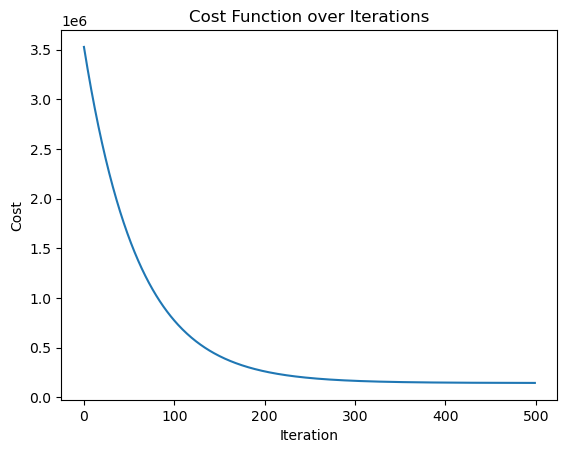

In [222]:
# Your code here
plt.plot(history['cost'])
plt.title('Cost Function over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

_Your answer here_

b) Imagine a stopping criterion, i.e. when do we stop iterating on the training set?

The stopping criterion could be based on the change in the cost function value between iterations. If the change is below a certain threshold (e.g., 0.001) for a specified number of consecutive iterations, we can consider that the algorithm has converged and stop iterating. Alternatively, we could set a maximum number of iterations to prevent excessive computation time. In our implementation, we have set a maximum of 10000 iterations and a threshold of 1e-6 for the change in cost function value. The formula used is:
$$|J(\theta^{(k)}) - J(\theta^{(k-1)})| / J(\theta^{(k-1)}) < \text{threshold}$$

where $J(\theta^{(k)})$ is the cost function value at iteration $k$ and $J(\theta^{(k-1)})$ is the cost function value at the previous iteration.

c) Plot the computed line $h_{\theta}(\mathbf{x})$ on top of the scatter plot of exercise 1.

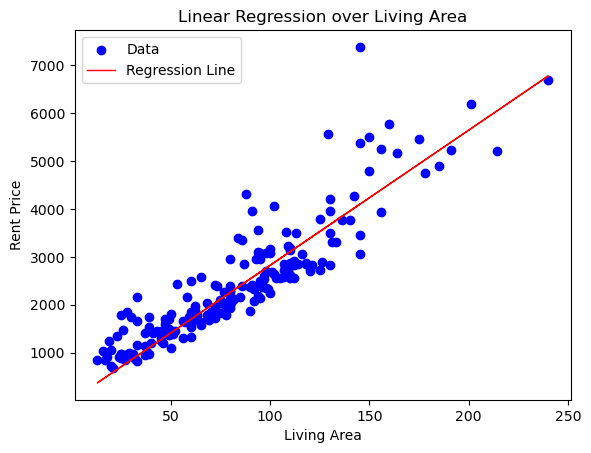

In [223]:
X = dataset["living_area"].values
y = dataset["rent_price"].values
plt.scatter(X, y, color='blue', label='Data')

# Compute predicted prices using the optimized theta
X_with_bias = np.c_[np.ones(len(X)), X]
prices = X_with_bias @ theta

# Plot the computed line (regression line)
plt.plot(X, prices, color='red', linewidth=1, label='Regression Line')

plt.xlabel('Living Area')
plt.ylabel('Rent Price')
plt.title('Linear Regression over Living Area')
plt.legend()
plt.show()

d) Compute the final cost value according to Equation 2 and compare it to the one of exercise 2. What can you conclude?

In [237]:
# Compute the final cost value for Exercise 3 (Gradient Descent)
# We use the theta obtained from gradient descent and the same X, y data from Exercise 2

# Data preparation for simple linear regression (living_area only)
X_simple = np.c_[np.ones(len(dataset["living_area"])), dataset["living_area"].values]
y_simple = dataset["rent_price"].values

# Final cost for Exercise 3 (Gradient Descent) - using the theta from GD
final_cost_gd = mse_cost(theta, X_simple, y_simple)

# For Exercise 2, we need to compute the cost using the normal equation solution
# From Exercise 2, we had multiple features (living_area and nb_rooms)
X_ex2 = dataset[['living_area', 'nb_rooms']].to_numpy(dtype=float)
y_ex2 = dataset['rent_price'].to_numpy(dtype=float)
X_ex2_with_bias = np.hstack((np.ones((X_ex2.shape[0], 1)), X_ex2))

# Use the theta_i calculated in Exercise 2
final_cost_normal = mse_cost(theta_i, X_ex2_with_bias, y_ex2)

print("=== COST COMPARISON ===")
print(f"Final cost from Exercise 2 (Normal Equations): {final_cost_normal:.6f}")
print(f"Final cost from Exercise 3 (Gradient Descent): {final_cost_gd:.6f}")
print(f"Difference: {abs(final_cost_gd - final_cost_normal):.6f}")

# Also compute the cost using the same single-feature setup for fair comparison
# Re-compute normal equation solution for single feature (living_area only)
theta_normal = np.dot(np.linalg.pinv(X_simple), y_simple)
cost_normal_single = mse_cost(theta_normal, X_simple, y_simple)

print("\n=== FAIR COMPARISON (Same features) ===")
print(f"Normal Equations (living_area only): {cost_normal_single:.6f}")
print(f"Gradient Descent (living_area only): {final_cost_gd:.6f}")
print(f"Difference: {abs(final_cost_gd - cost_normal_single):.6f}")

# Verify convergence
if abs(final_cost_gd - cost_normal_single) < 1e-4:
    print("Gradient Descent has converged to the optimal solution!")
else:
    print("Gradient Descent has not fully converged to the optimal solution.")

=== COST COMPARISON ===
Final cost from Exercise 2 (Normal Equations): 136966.116247
Final cost from Exercise 3 (Gradient Descent): 144605.414295
Difference: 7639.298049

=== FAIR COMPARISON (Same features) ===
Normal Equations (living_area only): 138034.957798
Gradient Descent (living_area only): 144605.414295
Difference: 6570.456497
Gradient Descent has not fully converged to the optimal solution.


The gradient descent did not fully converge to the global minimum, possibly because the learning rate (α) was too small, leading to very small update steps and an apparent convergence before reaching the true minimum. Another possible explanation is the absence of feature normalization, since X was built directly from living_area and nb_rooms without any scaling, which can make the cost surface elongated and slow down convergence along certain directions, preventing the algorithm from efficiently reaching the optimal solution.

## Exercise 4 - Stochastic gradient descent for linear regression

Implement the stochastic gradient descent algorithm for the previous problem. As seen in the theory, the update rules are:

$$\theta_{i} \leftarrow \theta_{i} - \alpha (h_{\theta}(\mathbf{x}_{n}) - y_{n}) x_{n,i} \tag{8}$$

In [224]:
def linear_regression_gradient_no_average(theta, X, y):
    """
    Gradient for linear regression WITHOUT averaging (pure SGD formula).
    ∇J = X^T · (X·theta - y)
    
    For single example (SGD): gradient = (h_theta(x_n) - y_n) * x_n
    """
    predictions = X.dot(theta)
    errors = predictions - y
    return X.T.dot(errors)

In [225]:
def stochastic_gradient_descent(initial_theta, alpha, gradient_fn, X, y,
                                cost_fn=None, convergence_delta=1e-6, 
                                max_iterations=10000):
    """Stochastic gradient descent (batch_size=1)"""
    return generalized_gradient_descent(
        initial_theta, alpha, gradient_fn, X, y,
        batch_size=1, 
        cost_fn=cost_fn,
        convergence_delta=convergence_delta,
        max_iterations=max_iterations
    )

In [ ]:
# Préparer les données
X = dataset['living_area'].to_numpy()
X_b = np.c_[np.ones((X.shape[0], 1)), X]
y = dataset['rent_price'].to_numpy()

initial_theta = np.zeros(2)
alpha = 0.00001
n_epochs = 2

theta, history = stochastic_gradient_descent(
    initial_theta,
    alpha,
    linear_regression_gradient_no_average,
    X_b,
    y,
    cost_fn=mse_cost,
    max_iterations=n_epochs
)

print("Final theta:", theta)
print("Final cost:", history['cost'][-1])
print(f"Total updates: {len(history['cost'])}")

Final theta: [ 0.51994755 28.5603111 ]
Final cost: 144186.19027136537
Total updates: 402


a) Plot the computed line $h_{\theta}(\mathbf{x})$ on top of the scatter plot of exercise 1.

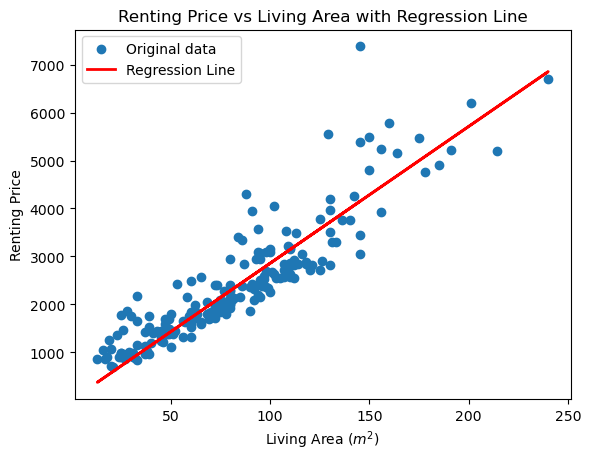

In [251]:
# Compute predictions for all data points using the latest theta and feature matrix
y_pred_all = X_b @ theta

plt.scatter(dataset['living_area'], dataset['rent_price'], label='Original data')
plt.plot(X, y_pred_all, color='red', linewidth=2, label='Regression Line')
plt.title('Renting Price vs Living Area with Regression Line')
plt.xlabel('Living Area ($m^2$)')
plt.ylabel('Renting Price')
plt.legend()
plt.show()

b) How many samples do you need to visit for reaching the convergence?

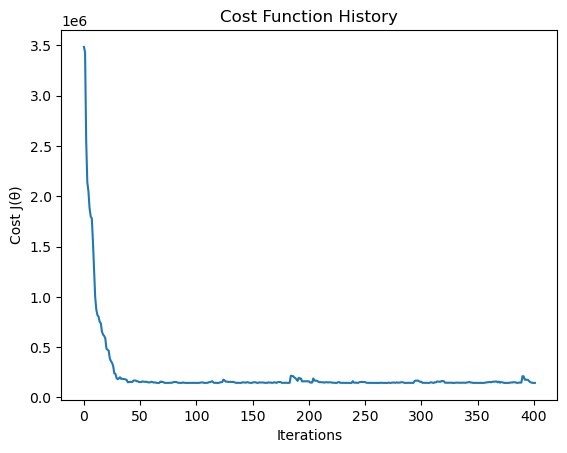

In [254]:
plt.plot(history['cost'])
plt.title('Cost Function History')
plt.xlabel('Iterations')
plt.ylabel('Cost J(θ)')
plt.show()

We start seeing convergence after around 30 samples. However, we can see that the cost function is still oscillating a little bit, which is typical for stochastic gradient descent.

c) What kind of stopping criterion could we use here?

We could use one of the following stopping criteria:
1. Set a maximum number of iterations.
2. Stop when the change in cost function between iterations is below a certain threshold.

d) Compute the final cost value according to Equation 2 and compare it to the one of exercise 2 and 3. What can you conclude?

In [256]:
# Your code here
final_cost_sgd = history['cost'][-1]
print("Final cost from SGD:", final_cost_sgd)

Final cost from SGD: 144186.19027136537


_Your answer here_

## Exercise 5 - Review questions

a) The linear regression has a mathematical _closed form_ solution. Then, in which conditions would we prefer a gradient descent algorithm to compute the regression model?

The closed form solution is not ideal for very large datasets or when the feature set is very large (high dimensionality). Indeed, this method requires the computation of the inverse of the matrix (X^TX), which can be computationally expensive and numerically unstable for large matrices. In such cases, gradient descent methods (like batch or stochastic gradient descent) are preferred as they can handle larger datasets more efficiently.

b) Outliers in a data set can be defined as values that are out of the "usual" range in comparison with other values. They typically come from noise or anomalies in the data capturing process. What is the impact of an outlier in the stochastic gradient descent process? What if we have many outliers? _Hint_: look at the equation of the MSE, and to the equation of the update rule.

Outliers can significantly impact the stochastic gradient descent process. Since the update rule in SGD is based on the error between the predicted and actual values, an outlier can cause a large error, leading to a disproportionately large update to the model parameters. This is even more emphasized in the Mean Squared Error (MSE) cost function, where the error is squared, amplifying the effect of outliers. If there are many outliers in the dataset, they can skew the model's learning process, leading to poor generalization on the overall data.

c) In the case of stochastic gradient descent, what is the danger of having a too large or too small $\alpha$ value? Could you think of a better (more advanced) strategy as the one stated in Slide 36?



- Too large α: If the learning rate α is too large, we may oscillate around the minimum or even diverge from it (we can bounce around the minimum). This can lead to an unstable training process where the cost function does not decrease and may even increase over iterations.
- Too small α: Conversely, if α is too small, the updates will be very small, leading to a slow convergence. This can result in a long training time and may cause the algorithm to get stuck in a local minimum.
- Better Strategy: A more advanced strategy could be to inspect the evolution of the cost function over iterations and adaptively adjust α based on the observed behavior. For instance, if the cost function is decreasing steadily, we could slightly increase α to speed up convergence. If we observe oscillations or increases in the cost function, we could decrease α to stabilize the training process. This adaptive learning rate approach can help balance convergence speed and stability.



d) Let's assume we expect that the target variable $y$ has a dependency to the square and to the cube of one of the feature $x_d$ in our multi-variable training set $(x_1, \ldots, x_d, \ldots, x_D)$. How would you proceed? Do we need to take precautions in terms of numerical stability?

To account for the dependency of the target variable `y` on the square and cube of a feature `x_d`, we can create new features in our dataset that represent these polynomial terms. Specifically, we can add two new features: `x_d^2` and `x_d^3`. This way, our model can learn the relationship between `y` and these polynomial terms.

Yes, we need to take precautions in terms of numerical stability. Squared or cubed features can lead to very large values, especially for higher degrees, which can cause numerical instability during the training process. To mitigate this, we can:
1. Normalize or standardize the features before adding polynomial terms.
2. Use regularization techniques to prevent overfitting on the squared and cubed terms.

e) _Advanced_. Could we use a descent algorithm without computing the gradient? If yes, give a pseudo code of the algorithm to find $(\theta_{0}, \theta_{1})$ using a linear regression $h_{\theta}(x) = \theta_0 + \theta_1 x$.

It seems possible to use a descent algorithm that do not require the explicit computation of gradients. We could follow these steps:
1. Initialize theta randomly.
2. Change theta slightly in a random direction.
3. Compute the cost function.
4. If the cost decreases, keep the change. Otherwise, revert it.
5. Repeat until the stopping criterion is met.

## Exercise 6 - Optional – Mini-batch gradient descent for linear regression

In [228]:
def mini_batch_gradient_descent(initial_theta, alpha, gradient_fn, X, y, B,
                                cost_fn=None, convergence_delta=1e-6, 
                                max_iterations=10000):
    """Mini-batch gradient descent with batch size B"""
    return generalized_gradient_descent(
        initial_theta, alpha, gradient_fn, X, y,
        batch_size=B, 
        cost_fn=cost_fn,
        convergence_delta=convergence_delta,
        max_iterations=max_iterations
    )

In [229]:
# If B = len(X) -> the behavior should match the batch gradient descent
initial_theta = np.zeros(2)

# Run standard batch gradient descent
theta_batch, history_batch = batch_gradient_descent(initial_theta, alpha, linear_regression_gradient, X_with_bias, y, cost_fn=mse_cost)
cost_batch = history_batch['cost']

# Run mini-batch gradient descent with B = len(X)
theta_mini, history_mini = mini_batch_gradient_descent(initial_theta, alpha, linear_regression_gradient, X_with_bias, y, B=len(X_with_bias), cost_fn=mse_cost)
cost_mini = history_mini['cost']

# Verify that both methods produce approximately the same parameters
assert np.allclose(theta_batch, theta_mini, atol=1e-6)

# If B = 1 -> the behavior should approach stochastic gradient descent
theta_sgd, history_sgd = mini_batch_gradient_descent(initial_theta, alpha, linear_regression_gradient_no_average, X_with_bias, y, B=1, cost_fn=mse_cost)
cost_sgd = history_sgd['cost']

# Alternative: you can also use the dedicated stochastic_gradient_descent function
# theta_sgd, history_sgd = stochastic_gradient_descent(initial_theta, alpha, linear_regression_gradient_no_average, X_with_bias, y, cost_fn=mse_cost)
# cost_sgd = history_sgd['cost']

# Display the resulting theta values for each approach
print("Theta from Batch GD:", theta_batch)
print("Theta from Mini-Batch GD (B=len(X)):", theta_mini)
print("Theta from Stochastic GD (B=1):", theta_sgd)

# Compare the final cost values between the different methods
print("Final Cost from Batch GD:", cost_batch[-1])
print("Final Cost from Mini-Batch GD (B=len(X)):", cost_mini[-1])
print("Final Cost from Stochastic GD (B=1):", cost_sgd[-1])

Theta from Batch GD: [ 0.32307382 28.64408647]
Theta from Mini-Batch GD (B=len(X)): [ 0.32307382 28.64408647]
Theta from Stochastic GD (B=1): [235.72224511  25.27749584]
Final Cost from Batch GD: 144160.061659794
Final Cost from Mini-Batch GD (B=len(X)): 144160.061659794
Final Cost from Stochastic GD (B=1): 143079.712827344


## Exercise 7 - Multi variable linear regression

### a

Implement one of the gradient descent algorithm (ex. 3-5) for the multi-variable linear regression assuming x1 being the living area and x2 the square of the living area. Plot the computed curve (second order) on top of the scatter plot of exercise 1. Do you observe a reduction in the loss ?

In [238]:
def normalize(x):
    return (x - np.mean(x)) / np.std(x), np.mean(x), np.std(x)

def compute_cost(X, y, theta):
    y_pred = X.dot(theta)
    return (1 / (2 * len(y))) * np.sum((y_pred - y) ** 2)

def gradient_descent(X, y, alpha=0.01, num_iters=1000):
    theta = np.zeros((X.shape[1], 1))
    cost_history = []
    for i in range(num_iters):
        y_pred = X.dot(theta)
        gradient = (1 / len(y)) * X.T.dot(y_pred - y)
        theta = theta - alpha * gradient
        cost = compute_cost(X, y, theta)
        cost_history.append(cost)
    return theta, cost_history


In [239]:
x1_a = dataset['living_area'].to_numpy()
x2_a = x1_a ** 2

y = dataset['rent_price'].to_numpy().reshape(-1, 1)

N = len(y)

# Normalize features
x1_norm, m1, s1 = normalize(x1_a)
x2_norm, m2, s2 = normalize(x2_a)

# Matrix with bias term
X_a = np.c_[np.ones(N), x1_norm, x2_norm]

In [240]:
alpha = 0.01
num_iters = 2000
theta_a, cost_a = gradient_descent(X_a, y, alpha, num_iters)

print("Final theta :", theta_a.ravel())
print("Final cost :", cost_a[-1])

Final theta : [2378.24377666  718.2152659   408.77750835]
Final cost : 134196.9696916851


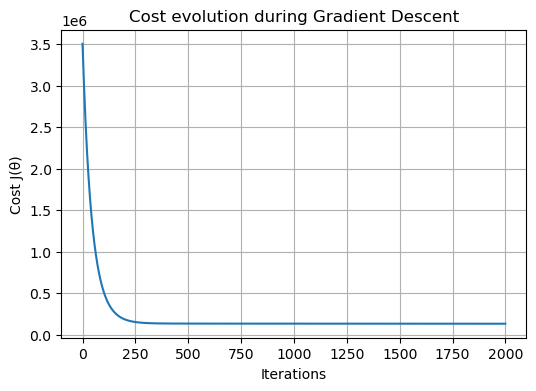

In [241]:
plt.figure(figsize=(6,4))
plt.plot(cost_a)
plt.xlabel("Iterations")
plt.ylabel("Cost J(θ)")
plt.title("Cost evolution during Gradient Descent")
plt.grid(True)
plt.show()

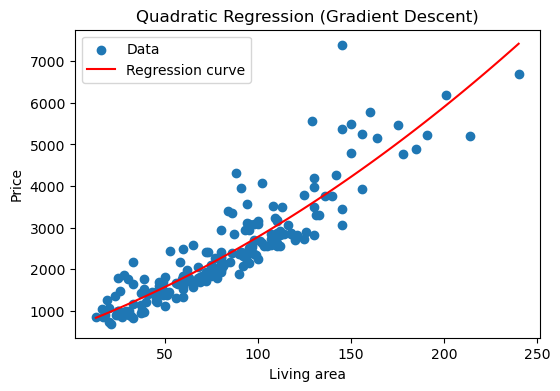

In [242]:
plt.figure(figsize=(6,4))
plt.scatter(x1_a, y, label="Data")
x_sorted = np.linspace(min(x1_a), max(x1_a), 100)
x1_s = (x_sorted - m1) / s1
x2_s = ((x_sorted ** 2) - m2) / s2
X_plot = np.c_[np.ones(len(x_sorted)), x1_s, x2_s]
y_pred = X_plot.dot(theta_a)
plt.plot(x_sorted, y_pred, color='red', label="Regression curve")
plt.xlabel("Living area")
plt.ylabel("Price")
plt.legend()
plt.title("Quadratic Regression (Gradient Descent)")
plt.show()

### b

Implement one of the gradient descent algorithm (ex. 3-5) for the multi-variable linear regression assuming x1 being the living area and x2 the number of bedrooms. Do you observe a reduction in the loss ?

In [243]:
x1_b = dataset['living_area'].to_numpy()
x2_b = dataset['nb_rooms'].to_numpy()

# Normalize features
x1_norm_b, m1b, s1b = normalize(x1_b)
x2_norm_b, m2b, s2b = normalize(x2_b)

# Matrix with bias term
X_b = np.c_[np.ones(N), x1_norm_b, x2_norm_b]

In [244]:
theta_b, cost_b = gradient_descent(X_b, y, alpha, num_iters)

print("Final theta :", theta_b.ravel())
print("Final cost :", cost_b[-1])

Final theta : [2378.24377666 1112.31660277   -9.97084372]
Final cost : 137891.84029018503


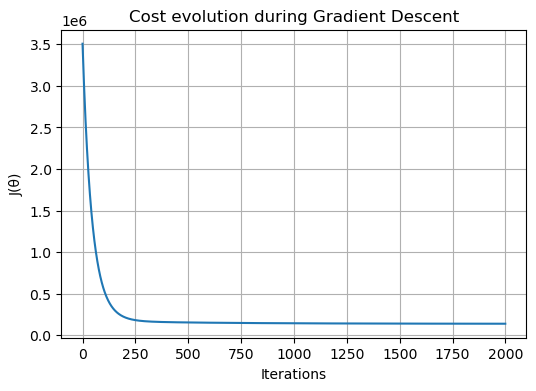

In [245]:
plt.figure(figsize=(6,4))
plt.plot(cost_b)
plt.xlabel("Iterations")
plt.ylabel("J(θ)")
plt.title("Cost evolution during Gradient Descent")
plt.grid(True)
plt.show()

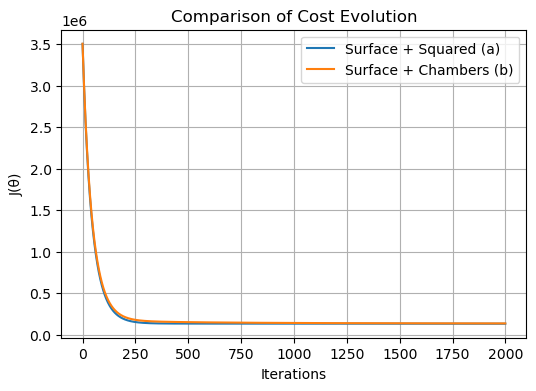

Final cost (a): 134196.9697
Final cost (b): 137891.8403


In [246]:
plt.figure(figsize=(6,4))
plt.plot(cost_a, label="Surface + Squared (a)")
plt.plot(cost_b, label="Surface + Chambers (b)")
plt.title("Comparison of Cost Evolution")
plt.xlabel("Iterations")
plt.ylabel("J(θ)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Final cost (a): {cost_a[-1]:.4f}")
print(f"Final cost (b): {cost_b[-1]:.4f}")